In [1]:
#import modules
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdna
import numpy as np
from scipy.stats import zscore
import gc
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Polygon, mapping


In [18]:
#Import graphml, convert to undirected
graphml_path = "olomouc_cz_2019_10000m_all_osm_20190902.graphml"
G = ox.load_graphml(graphml_path)
G_undirected = ox.save_load.get_undirected(G)
gdf_osm = ox.save_load.graph_to_gdfs(G_undirected, nodes=False, edges=True)


In [19]:
#Impport study area
osm_buffer_file="olomouc_cz_2019_1600m_buffer.gpkg"
gdf_study_area = gpd.read_file(osm_buffer_file, layer='urban_study_region')

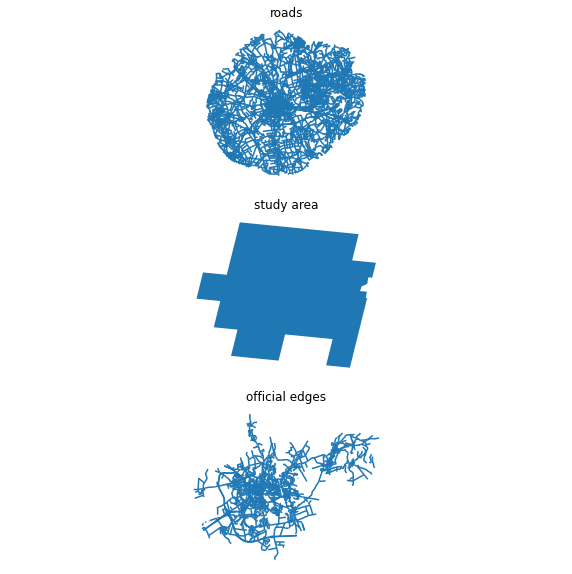

In [20]:
#pdf_study_area = gpd.read_file(graphml_path, layer='urban_study_region')
#Import official shape file of network
gdf_official = gpd.GeoDataFrame.from_file("Olomouc_Street_Network.shp")

#Convert crs of osm dataset and study area to crs to official dataset
gdf_osm = gdf_osm.to_crs(gdf_official.crs)
gdf_study_area = gdf_study_area.to_crs(gdf_official.crs)

#Plot the datasets
fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=( 10, 10))
gdf_osm.plot(ax=ax1)
gdf_study_area.plot(ax=ax2)
gdf_official.plot(ax=ax3)
ax1.set_title("roads")
ax2.set_title("study area")
ax3.set_title("official edges")
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
plt.axis('equal')
plt.show()

In [16]:

#gdf_official.to_file("olomouc_official.shp")


In [17]:
#gdf_study_area.to_file("olomouc_study_area.shp")

In [ ]:
#gdf_osm.to_file("olomouc_osm.shp")


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the ol

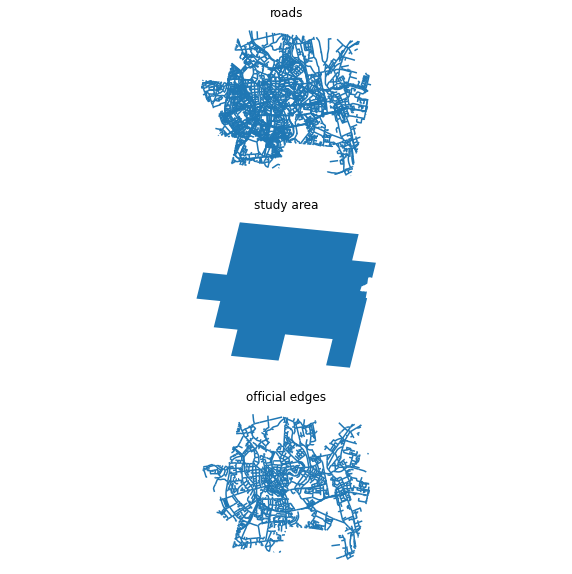

In [21]:
#Clip datasets by study are boundary
#mask1 = gdf_osm['geometry'].intersects(gdf_study_area['geometry'].unary_union)
osm_data = gpd.clip(gdf_osm, gdf_study_area)
#mask2 = gdf_official['geometry'].intersects(gdf_study_area['geometry'].unary_union)
official_data = gpd.clip(gdf_official, gdf_study_area)

#Plot the clipped dataset
fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=( 10, 10))
osm_data.plot(ax=ax1)
gdf_study_area.plot(ax=ax2)
official_data.plot(ax=ax3)
ax1.set_title("roads")
ax2.set_title("study area")
ax3.set_title("official edges")
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
plt.axis('equal')
plt.show()

In [22]:
#Calculating the total length of osm network
totallength = 0
count_osm = 0 
osmlength = osm_data.length
for i in osmlength:
    count_osm += 1
    totallength += i
print(totallength, count_osm)

616917.815688626 14186


In [23]:
#Calculate total length of official network
totallength2 = 0
count_of = 0 
oflength = official_data.length
for i in oflength:
    count_of += 1
    totallength2 += i
print(totallength2, count_of)

310456.16948370385 4149


In [42]:
#calculate areal intersection with various buffering 
buff = 0
percent_list = []
percent_dict = {}

while buff<20:
    
    
    #official_buffer = official_data
    #official_buffer = official_buffer.buffer(buff)

    osm_buffer = osm_data
    osm_buffer = osm_buffer.buffer(buff)

    
    osm_total = 0
    osm_areas = osm_buffer.area
    for i in osm_areas:
        osm_total += i
   # print(osm_areas[0:3])
    
    official_total = 0
    official_areas = official_buffer.area
    for i in official_areas:
        official_total += i
    #print(official_areas[0:3])
    print("osm areas: ", osm_total)
    print("official areas: ", official_total)
    
    intersected = gpd.clip(official_buffer, osm_buffer)

    totalshare = 0
    in_areas = intersected.area
    for i in in_areas:
        totalshare += i
    print(totalshare)
    percent_official_intersected = totalshare*100/official_total
    print("intersected: ",totalshare)
    print("intersected length: ", len(intersected))
    print("percent_official_intersected: ", percent_official_intersected)
    percent_dict[buff] = percent_official_intersected
    percent_list.append((buff,percent_official_intersected))
    buff += 2
    
   

osm areas:  7271756.171360372
official areas:  12245672.522113858


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


6473046.970382456
intersected:  6473046.970382456
intersected length:  4105
percent_official_intersected:  52.8598732220962
osm areas:  10798343.914435433
official areas:  12245672.522113858


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


8020413.9834676655
intersected:  8020413.9834676655
intersected length:  4108
percent_official_intersected:  65.49590452450852
osm areas:  14677346.26619089
official areas:  12245672.522113858


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


9212454.960060827
intersected:  9212454.960060827
intersected length:  4114
percent_official_intersected:  75.23029007532668
osm areas:  18908197.0249946
official areas:  12245672.522113858


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


10159645.114484606
intersected:  10159645.114484606
intersected length:  4116
percent_official_intersected:  82.96518705802235
osm areas:  23491474.600462366
official areas:  12245672.522113858


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


10926862.410735227
intersected:  10926862.410735227
intersected length:  4120
percent_official_intersected:  89.23039866534847
osm areas:  28427861.66342584
official areas:  12245672.522113858


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


11475219.397777898
intersected:  11475219.397777898
intersected length:  4122
percent_official_intersected:  93.70836413480242
osm areas:  33717813.42235098
official areas:  12245672.522113858


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


11635634.789954565
intersected:  11635634.789954565
intersected length:  4123
percent_official_intersected:  95.01834030709497
osm areas:  39361377.22897941
official areas:  12245672.522113858


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


11695212.796518791
intersected:  11695212.796518791
intersected length:  4127
percent_official_intersected:  95.5048632518874
osm areas:  45358614.882565886
official areas:  12245672.522113858


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


11739223.989319358
intersected:  11739223.989319358
intersected length:  4127
percent_official_intersected:  95.86426525876853
osm areas:  51709986.98750342
official areas:  12245672.522113858
11776421.097715016
intersected:  11776421.097715016
intersected length:  4127
percent_official_intersected:  96.16802242954444


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [45]:
for item in percent_list:
    print("buffer: ", item[0])
    print("Percent area intersected: ", item[1])
    print("-----------------------")


buffer:  0
Percent area intersected:  52.8598732220962
-----------------------
buffer:  2
Percent area intersected:  65.49590452450852
-----------------------
buffer:  4
Percent area intersected:  75.23029007532668
-----------------------
buffer:  6
Percent area intersected:  82.96518705802235
-----------------------
buffer:  8
Percent area intersected:  89.23039866534847
-----------------------
buffer:  10
Percent area intersected:  93.70836413480242
-----------------------
buffer:  12
Percent area intersected:  95.01834030709497
-----------------------
buffer:  14
Percent area intersected:  95.5048632518874
-----------------------
buffer:  16
Percent area intersected:  95.86426525876853
-----------------------
buffer:  18
Percent area intersected:  96.16802242954444
-----------------------
